## Docker specific configurations

Prepare python path

In [1]:
from sys import path
from pathlib import Path
path.append(str(Path("../../").resolve()))

## Prepare mesh

Generate mesh outside of the docker using the following commands:
```bash
gmsh metal.geo -2
../../tools/convert_msh.py metal.msh metal.xdmf
gmsh sibc.geo -2
../../tools/convert_msh.py sibc.msh sibc.xdmf
```

## Solution preparation

Import BeamImpedance2D module

In [2]:
import logging
import bi2d
from bi2d.esum import Esum
from bi2d.materials import vacuum, beam, steel
import numpy as np

Assign material indices. When setting index `-1` to SIBC material, boundary will be applied to all boundaries

In [3]:
beam.index = 1
vacuum.index = 2
steel.index = 3
steel_sibc = steel.copy()
steel_sibc.index = -1

Setup mesh and materials

In [4]:
m_metal = bi2d.Mesh("metal.xdmf")
m_sibc = bi2d.Mesh("sibc.xdmf")
mc_metal = bi2d.MaterialMap(m_metal, [beam, vacuum, steel])
mc_sibc = bi2d.MaterialMap(m_sibc, [beam, vacuum])

Configure solution

In [5]:
solution_metal = bi2d.Solution(mc_metal, Hcurl_order=2, H1_order=2)
solution_sibc = bi2d.Solution(mc_sibc, Hcurl_order=2, H1_order=2)

Enable info level logging

In [6]:
solution_metal.logger.setLevel(logging.INFO)
solution_sibc.logger.setLevel(logging.INFO)

## Calculate impedance

Calculate impedance in frequency range and save the results

In [7]:
%%time

data_metal = solution_metal.get_z(np.logspace(6, 12, num=30), beta=0.999, source_function=bi2d.SourceFunction.MONOPOLE)

INFO:bi2d.solution:Solving for f=1.00e+06, β=1.00
INFO:bi2d.solution:Solving for f=1.61e+06, β=1.00
INFO:bi2d.solution:Solving for f=2.59e+06, β=1.00
INFO:bi2d.solution:Solving for f=4.18e+06, β=1.00
INFO:bi2d.solution:Solving for f=6.72e+06, β=1.00
INFO:bi2d.solution:Solving for f=1.08e+07, β=1.00
INFO:bi2d.solution:Solving for f=1.74e+07, β=1.00
INFO:bi2d.solution:Solving for f=2.81e+07, β=1.00
INFO:bi2d.solution:Solving for f=4.52e+07, β=1.00
INFO:bi2d.solution:Solving for f=7.28e+07, β=1.00
INFO:bi2d.solution:Solving for f=1.17e+08, β=1.00
INFO:bi2d.solution:Solving for f=1.89e+08, β=1.00
INFO:bi2d.solution:Solving for f=3.04e+08, β=1.00
INFO:bi2d.solution:Solving for f=4.89e+08, β=1.00
INFO:bi2d.solution:Solving for f=7.88e+08, β=1.00
INFO:bi2d.solution:Solving for f=1.27e+09, β=1.00
INFO:bi2d.solution:Solving for f=2.04e+09, β=1.00
INFO:bi2d.solution:Solving for f=3.29e+09, β=1.00
INFO:bi2d.solution:Solving for f=5.30e+09, β=1.00
INFO:bi2d.solution:Solving for f=8.53e+09, β=1.00


CPU times: user 15min 9s, sys: 25.8 s, total: 15min 35s
Wall time: 15min 35s


In [8]:
%%time

data_sibc = solution_sibc.get_z(np.logspace(6, 12, num=30), beta=0.999, source_function=bi2d.SourceFunction.MONOPOLE, sibc=[steel_sibc])

INFO:bi2d.solution:Solving for f=1.00e+06, β=1.00
INFO:bi2d.solution:Solving for f=1.61e+06, β=1.00
INFO:bi2d.solution:Solving for f=2.59e+06, β=1.00
INFO:bi2d.solution:Solving for f=4.18e+06, β=1.00
INFO:bi2d.solution:Solving for f=6.72e+06, β=1.00
INFO:bi2d.solution:Solving for f=1.08e+07, β=1.00
INFO:bi2d.solution:Solving for f=1.74e+07, β=1.00
INFO:bi2d.solution:Solving for f=2.81e+07, β=1.00
INFO:bi2d.solution:Solving for f=4.52e+07, β=1.00
INFO:bi2d.solution:Solving for f=7.28e+07, β=1.00
INFO:bi2d.solution:Solving for f=1.17e+08, β=1.00
INFO:bi2d.solution:Solving for f=1.89e+08, β=1.00
INFO:bi2d.solution:Solving for f=3.04e+08, β=1.00
INFO:bi2d.solution:Solving for f=4.89e+08, β=1.00
INFO:bi2d.solution:Solving for f=7.88e+08, β=1.00
INFO:bi2d.solution:Solving for f=1.27e+09, β=1.00
INFO:bi2d.solution:Solving for f=2.04e+09, β=1.00
INFO:bi2d.solution:Solving for f=3.29e+09, β=1.00
INFO:bi2d.solution:Solving for f=5.30e+09, β=1.00
INFO:bi2d.solution:Solving for f=8.53e+09, β=1.00


CPU times: user 3min 33s, sys: 8.12 s, total: 3min 41s
Wall time: 3min 43s


Notice significant time difference between two calculations. 

## Plot impedances

In [9]:
import pylab
pylab.rcParams['figure.figsize'] = [12, 8]

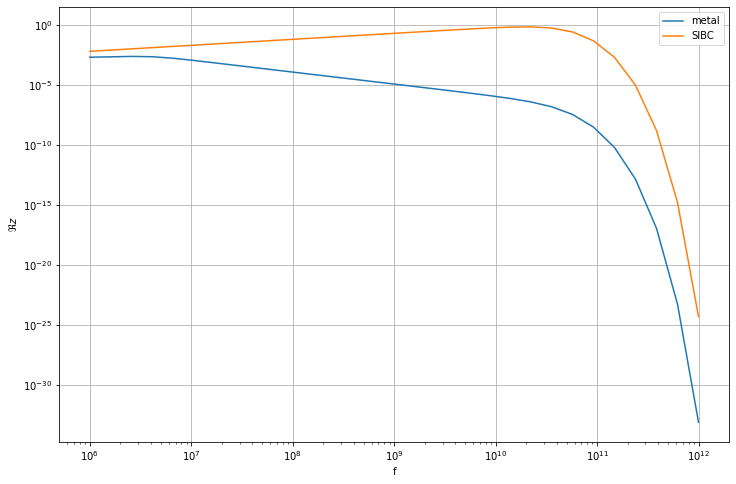

In [10]:
pylab.plot(data_metal[:,0], data_metal[:,1])
pylab.plot(data_sibc[:,0], data_sibc[:,1])
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f")
pylab.ylabel(r"$\Re{z}$")
pylab.grid()
pylab.legend([r"metal", r"SIBC"])
pylab.show()

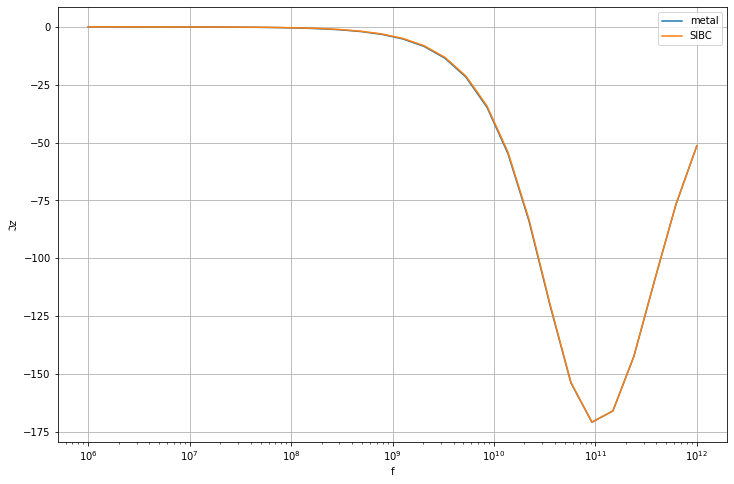

In [11]:
pylab.plot(data_metal[:,0], data_metal[:,2])
pylab.plot(data_sibc[:,0], data_sibc[:,2])
pylab.xscale("log")
pylab.xlabel("f")
pylab.ylabel(r"$\Im{z}$")
pylab.grid()
pylab.legend([r"metal", r"SIBC"])
pylab.show()